# Install Packages

In [1]:
!pip install --upgrade fairlearn==0.7.0 raiwidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 4.7 MB/s 
     |████████████████████████████████| 2.3 MB 51.0 MB/s 
     |████████████████████████████████| 129 kB 62.3 MB/s 
     |████████████████████████████████| 792 kB 47.1 MB/s 
     |████████████████████████████████| 5.8 MB 53.1 MB/s 
     |████████████████████████████████| 251 kB 47.6 MB/s 
     |████████████████████████████████| 1.6 MB 50.1 MB/s 
     |████████████████████████████████| 130 kB 77.0 MB/s 
     |████████████████████████████████| 3.4 MB 43.6 MB/s 
     |████████████████████████████████| 1.6 MB 48.9 MB/s 
     |████████████████████████████████| 213 kB 50.7 MB/s 
     |████████████████████████████████| 3.3 MB 39.2 MB/s 
     |████████████████████████████████| 164 kB 43.5 MB/s 
     |████████████████████████████████| 77 kB 6.2 MB/s 
     |████████████████████████████████| 564 kB 47.3 MB/s 
     |████████████████████████████

# Import Modules

In [2]:
import os
from pathlib import Path
from google.colab import drive
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import shap

from fairlearn.metrics import selection_rate, MetricFrame
from fairlearn.reductions import GridSearch, EqualizedOdds, FalsePositiveRateParity


# Set Hyperparameters

In [3]:
# set seed for reproducibility
seed = 123

# define features and target
features = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age']
target = 'Diabetic'

# Mount Google Drive and Set Paths

In [4]:
# mount data
gdrive_path = '/content/gdrive' 
drive.mount(gdrive_path)

# set paths
ROOTDIR = os.path.join(gdrive_path, 'MyDrive', 'Healthrisk_Modeling')
DATAPATH = os.path.join(ROOTDIR, 'data')
MODELPATH = os.path.join(ROOTDIR, 'model')

# make folders
Path(DATAPATH).mkdir(parents=True, exist_ok=True)
Path(MODELPATH).mkdir(parents=True, exist_ok=True)

Mounted at /content/gdrive


# Helper Functions

In [5]:
def make_sensitive_feature_array(X:pd.DataFrame, feature_name:str, feature_threshold:int)-> pd.DataFrame:
  """ Take X_train or X_test and return sensitive feature arrays for given feature name. 
      E.g. assuming age is the sensitive feature, then feature_threshold defines the border of the two classes younger or older that age threshold"""
  # make age to be sensitive 
  S = X[[feature_name]].copy()
  # replace nan values with mean age
  S.replace(np.nan, S.median(), inplace=True)
  # replace age values with the two classes younger or older than 40
  ind_1 = S <= feature_threshold
  ind_2 = S > feature_threshold
  S[ind_1] = str(feature_threshold) + ' or below'
  S[ind_2] = 'above ' + str(feature_threshold)
  return S

# Data Import

In [6]:
# load the diabetes dataset containing the artificially generated NAs
print("Loading Data...")
df = pd.read_csv(Path(DATAPATH) / 'diabetes_nas.csv')
df.head()

Loading Data...


,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0.0,171.0,80.0,34.0,23.0,43.509726,1.213191,21.0,0
1,1147438,8.0,NaN,93.0,47.0,36.0,21.240576,0.158365,23.0,0
2,1640031,7.0,115.0,47.0,52.0,35.0,41.511523,0.079019,23.0,0
3,1883350,9.0,103.0,78.0,25.0,304.0,29.582192,1.282870,43.0,1
4,1424119,1.0,85.0,59.0,27.0,NaN,42.604536,0.549542,22.0,0


# Train Test Split

In [7]:
# get features and target
X = df[features]
y = df[target]

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7000, 8), (7000,), (3000, 8), (3000,))

# Import Model Pipeline

In [9]:
# Load the model from the file
filename = '/diabetes_model.pkl'
model = joblib.load(MODELPATH + filename)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [7])])),
                ('gbc', GradientBoostingClassifier(random_state=123))])

In [10]:
# predict on a new sample
# The model accepts an array of feature arrays (so you can predict the classes of multiple patients in a single call)
# We'll create an array with a single array of features, representing one patient
X_new = np.array([[2,180,74,24,21,23,1.4,22]])
print ('New sample: {}'.format(list(X_new[0])))

# Get a prediction
pred = model.predict(X_new)
pred

New sample: [2.0, 180.0, 74.0, 24.0, 21.0, 23.0, 1.4, 22.0]


X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but OneHotEncoder was fitted with feature names


array([1])

# Model Fairness

## Define Sensitive Feature

In [11]:
# get sensitive feature array for train and test
sensitive_feature = 'Age'
age_treshold = 40
S_train = make_sensitive_feature_array(X_train, sensitive_feature, age_treshold)
S_test = make_sensitive_feature_array(X_test, sensitive_feature, age_treshold)
S_test.head()

,Age
2656,40 or below
445,above 40
9505,40 or below
332,above 40
4168,40 or below


In [12]:
# Get predictions for test data
y_pred = model.predict(X_test)

In [13]:
# Get metrics by sensitive group from fairlearn
print('\nMetrics by Group:')
metrics = {'selection_rate': selection_rate,
           'accuracy': accuracy_score,
           'recall': recall_score,
           'precision': precision_score,
           'f1': f1_score}

group_metrics = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=S_test)

print(group_metrics.by_group)


Metrics by Group:
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.255399  0.922757  0.845411  0.853659  0.849515
above 40            0.6875  0.929054  0.935561  0.963145  0.949153


In [14]:
# eliminate NA values and replace with median
for feature in features:
  print(feature)
  X_train[feature].replace(np.nan, X_train[feature].median(), inplace=True)
  X_test[feature].replace(np.nan, X_test[feature].median(), inplace=True)

Pregnancies
PlasmaGlucose
DiastolicBloodPressure
TricepsThickness
SerumInsulin
BMI
DiabetesPedigree
Age


In [15]:
# Mitigate Selection Parity

print('Finding mitigated models...')

# Train multiple models
sweep = GridSearch(GradientBoostingClassifier(random_state=seed),
                   constraints=EqualizedOdds(),
                   grid_size=40)

sweep.fit(X_train, y_train, sensitive_features=S_train)
models = sweep.predictors_

Finding mitigated models...


Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Seri

In [16]:
models

[GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoostingClassifier(random_state=123),
 GradientBoos

In [17]:
# Compare two different models

# first model
y_pred = models[0].predict(X_test)
group_metrics = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=S_test)

print(group_metrics.by_group)

# last model
y_pred = models[-1].predict(X_test)
group_metrics = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=S_test)

print(group_metrics.by_group)

            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.270764   0.91985  0.869565  0.828221   0.84839
above 40          0.680743  0.935811  0.935561  0.972705  0.953771
            selection_rate accuracy recall precision        f1
Age                                                           
40 or below            0.0  0.74211    0.0       0.0       0.0
above 40               1.0  0.70777    1.0   0.70777  0.828882


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [18]:
# show model fairness for all models
for model in models:
  y_pred = model.predict(X_test)
  group_metrics = MetricFrame(metrics=metrics,
                              y_true=y_test,
                              y_pred=y_pred,
                              sensitive_features=S_test)

  print('---------------------------------------------\n')
  print('Model Fairness Metrics: ')
  print(group_metrics.by_group)
  print('---------------------------------------------\n')

---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.270764   0.91985  0.869565  0.828221   0.84839
above 40          0.680743  0.935811  0.935561  0.972705  0.953771
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.305648  0.913206  0.924316  0.779891  0.845984
above 40               0.0   0.29223       0.0       0.0       0.0
---------------------------------------------



Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.265365  0.920266  0.859903  0.835681  0.847619
above 40          0.684122  0.929054  0.933174  0.965432  0.949029
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below            0.0   0.74211       0.0       0.0       0.0
above 40          0.728041  0.922297  0.959427  0.932715  0.945882
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.300249  0.909468  0.906602    0.7787  0.837798
above 40               0.0   0.29223       0.0       0.0       0.0
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.262874  0.919435  0.853462  0.837283  0.845295
above 40          0.692568  0.923986  0.935561  0.956098  0.945718
---------------------------------------------



Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy  recall precision        f1
Age                                                             
40 or below            0.0   0.74211     0.0       0.0       0.0
above 40          0.746622  0.910473  0.9642  0.914027  0.938444
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate accuracy    recall precision        f1
Age                                                              
40 or below            0.0  0.74211       0.0       0.0       0.0
above 40          0.768581  0.89527  0.968974  0.892308  0.929062
---------------------------------------------



Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.344269  0.887874  0.950081  0.711701  0.813793
above 40               0.0   0.29223       0.0       0.0       0.0
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.321013  0.903654  0.935588  0.751617  0.833572
above 40               0.0   0.29223       0.0       0.0       0.0
---------------------------------------------



Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.296512  0.914037  0.908213  0.789916  0.844944
above 40               0.0   0.29223       0.0       0.0       0.0
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.254983  0.922342    0.8438   0.85342  0.848583
above 40          0.711149  0.932432  0.954654  0.950119  0.952381
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy   recall precision        f1
Age                                                              
40 or below           

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy   recall precision        f1
Age                                                              
40 or below            0.0   0.74211      0.0       0.0       0.0
above 40          0.775338  0.891892  0.97136   0.88671  0.927107
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below            0.0   0.74211       0.0       0.0       0.0
above 40          0.782095  0.891892  0.976134  0.883369  0.927438
---------------------------------------------



Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.355482  0.881645  0.959742  0.696262  0.807041
above 40               0.0   0.29223       0.0       0.0       0.0
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy   recall precision       f1
Age                                                             
40 or below       0.337209  0.892442  0.94525  0.722906  0.81926
above 40               0.0   0.29223      0.0       0.0      0.0
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.313538  

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below            0.0   0.74211       0.0       0.0       0.0
above 40          0.773649  0.890203  0.968974  0.886463  0.925884
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below            0.0   0.74211       0.0       0.0       0.0
above 40           0.79223  0.881757  0.976134  0.872068  0.921171
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below         

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy   recall precision        f1
Age                                                              
40 or below            0.0   0.74211      0.0       0.0       0.0
above 40          0.805743  0.881757  0.98568  0.865828  0.921875
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.333472  0.894518  0.942029  0.728518  0.821629
above 40               0.0   0.29223       0.0       0.0       0.0
---------------------------------------------



Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.313953  0.905731  0.925926  0.760582  0.835149
above 40               0.0   0.29223       0.0       0.0       0.0
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.288621  0.916944  0.898551  0.802878  0.848024
above 40               0.0   0.29223       0.0       0.0       0.0
---------------------------------------------



Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision       f1
Age                                                              
40 or below       0.248754  0.923588  0.834138  0.864775  0.84918
above 40          0.804054  0.886824  0.988067  0.869748  0.92514
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below            0.0   0.74211       0.0       0.0       0.0
above 40          0.814189  0.869932  0.983294  0.854772  0.914539
---------------------------------------------



Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below            0.0   0.74211       0.0       0.0       0.0
above 40          0.826014  0.858108  0.983294  0.842536  0.907489
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below            0.0   0.74211       0.0       0.0       0.0
above 40          0.831081  0.853041  0.983294  0.837398  0.904501
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model Fairness Metrics: 
            selection_rate accuracy recall precision        f1
Age                                                           
40 or below            0.0  0.74211    0.0       0.0       0.0
above 40               1.0  0.70777    1.0   0.70777  0.828882
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate accuracy recall precision        f1
Age                                                           
40 or below            0.0  0.74211    0.0       0.0       0.0
above 40               1.0  0.70777    1.0   0.70777  0.828882
---------------------------------------------

---------------------------------------------

Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.284468  0.912791  0.882448      

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [19]:
# Get predictions from all models them (plus the original unmitigated one for comparison)
model_name = 'diabetis_model_unmitigated'
print(model_name)
predictions = {model_name: model.predict(X_test)}
i = 0
for model in models:
    i += 1
    model_name = 'diabetis_model_mitigated_{0}'.format(i)
    print(model_name)
    predictions[model_name] = model.predict(X_test)

diabetis_model_unmitigated
diabetis_model_mitigated_1
diabetis_model_mitigated_2
diabetis_model_mitigated_3
diabetis_model_mitigated_4
diabetis_model_mitigated_5
diabetis_model_mitigated_6
diabetis_model_mitigated_7
diabetis_model_mitigated_8
diabetis_model_mitigated_9
diabetis_model_mitigated_10
diabetis_model_mitigated_11
diabetis_model_mitigated_12
diabetis_model_mitigated_13
diabetis_model_mitigated_14
diabetis_model_mitigated_15
diabetis_model_mitigated_16
diabetis_model_mitigated_17
diabetis_model_mitigated_18
diabetis_model_mitigated_19
diabetis_model_mitigated_20
diabetis_model_mitigated_21
diabetis_model_mitigated_22
diabetis_model_mitigated_23
diabetis_model_mitigated_24
diabetis_model_mitigated_25
diabetis_model_mitigated_26
diabetis_model_mitigated_27
diabetis_model_mitigated_28
diabetis_model_mitigated_29
diabetis_model_mitigated_30
diabetis_model_mitigated_31
diabetis_model_mitigated_32
diabetis_model_mitigated_33
diabetis_model_mitigated_34
diabetis_model_mitigated_35
di

In [20]:
group_metrics.by_group

,selection_rate,accuracy,recall,precision,f1
Age,,,,,
40 or below,0.0,0.74211,0.0,0.0,0.0
above 40,1.0,0.70777,1.0,0.70777,0.828882


In [21]:
print('f1 younger 40: ', group_metrics.by_group.f1[0])
print('f1 older 40: ', group_metrics.by_group.f1[1])

f1 younger 40:  0.0
f1 older 40:  0.8288822947576657


In [22]:
# show model fairness for all models
model_fairness = {}

# calculate group metric for the unmitigated model
group_metrics = MetricFrame(metrics=metrics,
                            y_true=y_test,
                            y_pred=model.predict(X_test),
                            sensitive_features=S_test)

# get accuracy for females
f1_old = group_metrics.by_group.f1[1]
# get r2 for males
f1_young = group_metrics.by_group.f1[0]
# show the r2 difference between men and women
f1_diff = np.abs(f1_old - f1_young)

# track model performance and faireness
model_fairness['model_unmitigated'] = [f1_old, f1_young, f1_diff]


counter = 0
for model in models:
  counter += 1
  y_pred = model.predict(X_test)
  group_metrics = MetricFrame(metrics=metrics,
                              y_true=y_test,
                              y_pred=y_pred,
                              sensitive_features=S_test)

  # get accuracy for females
  f1_old = group_metrics.by_group.f1[1]
  # get r2 for males
  f1_young = group_metrics.by_group.f1[0]
  # show the r2 difference between men and women
  f1_diff = np.abs(f1_old - f1_young)

  # track model performance and faireness
  model_fairness['model_mitigated #'+str(counter)] = [f1_old, f1_young, f1_diff] 


  print('---------------------------------------------\n')
  print('Model #', counter)
  print('Model Fairness Metrics: ')
  print(group_metrics.by_group)
  print(' F1 Difference Men vs Women: f1-diff={:.2f}'.format(f1_diff))
  print('---------------------------------------------\n')

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model # 1
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.270764   0.91985  0.869565  0.828221   0.84839
above 40          0.680743  0.935811  0.935561  0.972705  0.953771
 F1 Difference Men vs Women: f1-diff=0.11
---------------------------------------------

---------------------------------------------

Model # 2
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.305648  0.913206  0.924316  0.779891  0.845984
above 40               0.0   0.29223       0.0       0.0       0.0
 F1 Difference Men vs Women: f1-diff=0.85
---------------------------------------------



Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model # 3
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.265365  0.920266  0.859903  0.835681  0.847619
above 40          0.684122  0.929054  0.933174  0.965432  0.949029
 F1 Difference Men vs Women: f1-diff=0.10
---------------------------------------------

---------------------------------------------

Model # 4
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below            0.0   0.74211       0.0       0.0       0.0
above 40          0.728041  0.922297  0.959427  0.932715  0.945882
 F1 Difference Men vs Women: f1-diff=0.95
---------------------------------------------



Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model # 5
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.325581  0.899086  0.935588  0.741071  0.827046
above 40               0.0   0.29223       0.0       0.0       0.0
 F1 Difference Men vs Women: f1-diff=0.83
---------------------------------------------

---------------------------------------------

Model # 6
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.300249  0.909468  0.906602    0.7787  0.837798
above 40               0.0   0.29223       0.0       0.0       0.0
 F1 Difference Men vs Women: f1-diff=0.84
---------------------------------------------

---------------------------------------------

Model # 7
Model Fairness Metrics: 
            selection_rate  accuracy    

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


 9
Model Fairness Metrics: 
            selection_rate accuracy    recall precision        f1
Age                                                              
40 or below            0.0  0.74211       0.0       0.0       0.0
above 40          0.768581  0.89527  0.968974  0.892308  0.929062
 F1 Difference Men vs Women: f1-diff=0.93
---------------------------------------------

---------------------------------------------

Model # 10
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.344269  0.887874  0.950081  0.711701  0.813793
above 40               0.0   0.29223       0.0       0.0       0.0
 F1 Difference Men vs Women: f1-diff=0.81
---------------------------------------------



Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model # 11
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.321013  0.903654  0.935588  0.751617  0.833572
above 40               0.0   0.29223       0.0       0.0       0.0
 F1 Difference Men vs Women: f1-diff=0.83
---------------------------------------------

---------------------------------------------

Model # 12
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.296512  0.914037  0.908213  0.789916  0.844944
above 40               0.0   0.29223       0.0       0.0       0.0
 F1 Difference Men vs Women: f1-diff=0.84
---------------------------------------------

---------------------------------------------

Model # 13
Model Fairness Metrics: 
            selection_rate  accuracy 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model # 16
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below            0.0   0.74211       0.0       0.0       0.0
above 40          0.782095  0.891892  0.976134  0.883369  0.927438
 F1 Difference Men vs Women: f1-diff=0.93
---------------------------------------------

---------------------------------------------

Model # 17
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.355482  0.881645  0.959742  0.696262  0.807041
above 40               0.0   0.29223       0.0       0.0       0.0
 F1 Difference Men vs Women: f1-diff=0.81
---------------------------------------------



Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model # 18
Model Fairness Metrics: 
            selection_rate  accuracy   recall precision       f1
Age                                                             
40 or below       0.337209  0.892442  0.94525  0.722906  0.81926
above 40               0.0   0.29223      0.0       0.0      0.0
 F1 Difference Men vs Women: f1-diff=0.82
---------------------------------------------

---------------------------------------------

Model # 19
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.313538  0.906977  0.927536  0.762914  0.837209
above 40               0.0   0.29223       0.0       0.0       0.0
 F1 Difference Men vs Women: f1-diff=0.84
---------------------------------------------



Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model # 20
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.289867  0.915698  0.898551  0.799427  0.846096
above 40               0.0   0.29223       0.0       0.0       0.0
 F1 Difference Men vs Women: f1-diff=0.85
---------------------------------------------

---------------------------------------------

Model # 21
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.254983  0.920681   0.84058  0.850163  0.845344
above 40          0.743243  0.930743  0.976134  0.929545   0.95227
 F1 Difference Men vs Women: f1-diff=0.11
---------------------------------------------

---------------------------------------------

Model # 22
Model Fairness Metrics: 
            selection_rate  accuracy 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model # 24
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below            0.0   0.74211       0.0       0.0       0.0
above 40          0.807432  0.886824  0.990453  0.868201  0.925307
 F1 Difference Men vs Women: f1-diff=0.93
---------------------------------------------

---------------------------------------------

Model # 25
Model Fairness Metrics: 
            selection_rate  accuracy   recall precision        f1
Age                                                              
40 or below            0.0   0.74211      0.0       0.0       0.0
above 40          0.805743  0.881757  0.98568  0.865828  0.921875
 F1 Difference Men vs Women: f1-diff=0.92
---------------------------------------------

---------------------------------------------

Model # 26
Model Fairness Metrics: 
            selection_rate  accuracy    r

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model # 27
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.313953  0.905731  0.925926  0.760582  0.835149
above 40               0.0   0.29223       0.0       0.0       0.0
 F1 Difference Men vs Women: f1-diff=0.84
---------------------------------------------

---------------------------------------------

Model # 28
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.288621  0.916944  0.898551  0.802878  0.848024
above 40               0.0   0.29223       0.0       0.0       0.0
 F1 Difference Men vs Women: f1-diff=0.85
---------------------------------------------

---------------------------------------------

Model # 29
Model Fairness Metrics: 
            selection_rate  accuracy 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

Model # 32
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below            0.0   0.74211       0.0       0.0       0.0
above 40          0.831081  0.853041  0.983294  0.837398  0.904501
 F1 Difference Men vs Women: f1-diff=0.90
---------------------------------------------

---------------------------------------------

Model # 33
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.312292    0.9049  0.921095  0.760638  0.833212
above 40          0.148649  0.153716   0.00716  0.034091  0.011834
 F1 Difference Men vs Women: f1-diff=0.82
---------------------------------------------

---------------------------------------------

Model # 34
Model Fairness Metrics: 
            selection_rate  accuracy 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------------------

---------------------------------------------

Model # 37
Model Fairness Metrics: 
            selection_rate accuracy recall precision        f1
Age                                                           
40 or below            0.0  0.74211    0.0       0.0       0.0
above 40               1.0  0.70777    1.0   0.70777  0.828882
 F1 Difference Men vs Women: f1-diff=0.83
---------------------------------------------

---------------------------------------------

Model # 38
Model Fairness Metrics: 
            selection_rate  accuracy    recall precision        f1
Age                                                               
40 or below       0.284468  0.912791  0.882448       0.8  0.839204
above 40            0.3125   0.10473  0.088305       0.2  0.122517
 F1 Difference Men vs Women: f1-diff=0.72
---------------------------------------------

---------------------------------------------

Model # 39
Model Fairness Metrics: 
      

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [23]:
# transform fairness and performance dict to dataframe
df_fairness = pd.DataFrame(model_fairness, index=['f1_old', 'f1_young', 'f1_diff']).T
df_fairness.head()

,f1_old,f1_young,f1_diff
model_unmitigated,0.828882,0.000000,0.828882
model_mitigated #1,0.953771,0.848390,0.105382
model_mitigated #2,0.000000,0.845984,0.845984
model_mitigated #3,0.949029,0.847619,0.101410
model_mitigated #4,0.945882,0.000000,0.945882


In [24]:
# add f2 averaged over both groups
df_fairness['f1_group_average'] = 0.5*(df_fairness['f1_old'] + df_fairness['f1_young'])
df_fairness.head()

,f1_old,f1_young,f1_diff,f1_group_average
model_unmitigated,0.828882,0.000000,0.828882,0.414441
model_mitigated #1,0.953771,0.848390,0.105382,0.901080
model_mitigated #2,0.000000,0.845984,0.845984,0.422992
model_mitigated #3,0.949029,0.847619,0.101410,0.898324
model_mitigated #4,0.945882,0.000000,0.945882,0.472941


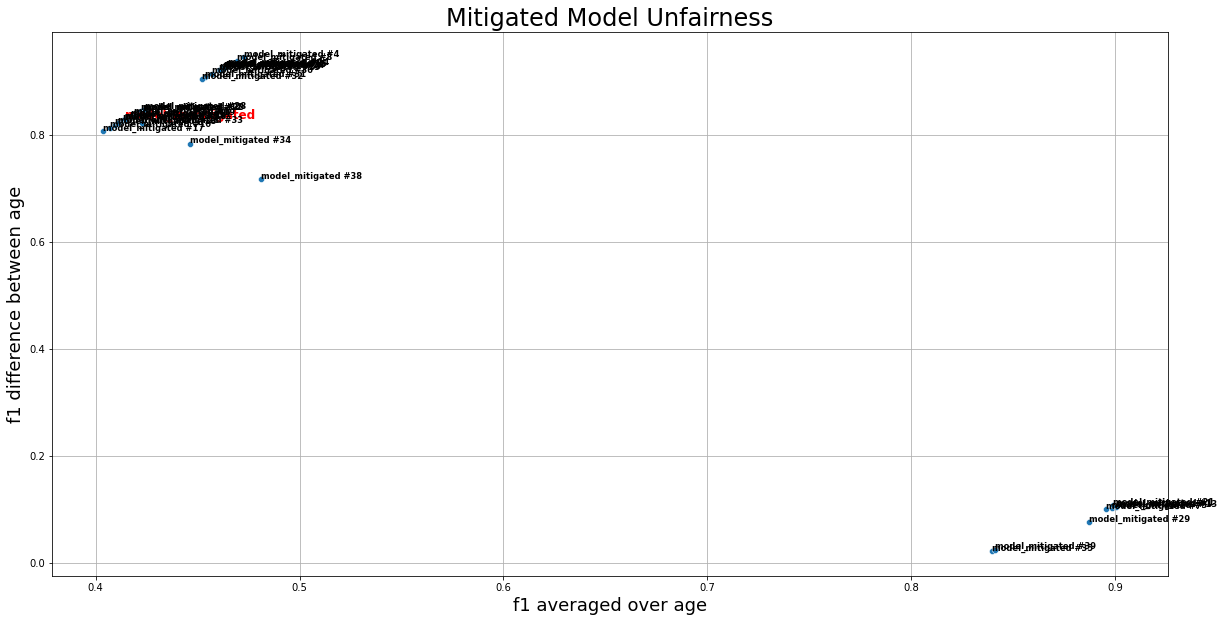

In [25]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x='f1_group_average', 
                     y='f1_diff', 
                     data=df_fairness)

# plot unmitigated model
line = 0
ax.text(df_fairness.f1_group_average[line], df_fairness.f1_diff[line]+0.001, 
df_fairness.index[line], horizontalalignment='left', 
size='large', color='red', weight='bold')

# plot mitigated models
for line in range(1, df_fairness.shape[0]):
  ax.text(df_fairness.f1_group_average[line], df_fairness.f1_diff[line]+0.001, 
  df_fairness.index[line], horizontalalignment='left', 
  size='small', color='black', weight='semibold')

ax.set_xlabel('f1 averaged over age', size=18)
ax.set_ylabel('f1 difference between age', size=18)
ax.set_title('Mitigated Model Unfairness', size=24)
ax.grid('on')

plt.show()

## Fairness Dashboard

In [26]:
from raiwidgets import FairnessDashboard

In [27]:
FairnessDashboard(sensitive_features=S_test,
                  y_true=y_test,
                  y_pred=predictions)

Output hidden; open in https://colab.research.google.com to view.